## Базовые требования к домашкам

1. Формат - jupyter-тетрадка или скрипт на питоне
2. Мы запускаем ваши тетрадки с нуля, поэтому следите, чтобы не было 
- необъявленных переменных (удалили ячейку, а переменная продолжает использоваться)
- лишних принтов отладочной информации
3. Комментарии приветствуются!

## Задание
В рамках этого задания мы будем создавать программу, которая получая на вход отзыв, будет предсказывать, является отзыв положительным или отрицательным. Делать мы будем это таким образом: мы возьмём некоторое число заранее размеченных как положительные или отрицательные отзывов, выделим те слова, которые встречаются только в положительных или только в отрицательных отзывах, и будем считать, каких слов  в поступившем нам на проверку отзыве больше.


Мы будем работать по заранее определённому пайплайну:

1.  Сначала нам надо скачать дату -- соберите как минимум 60 (30 положительных  и 30 отрицательных) отзывов на похожие продукты (не надо мешать отзывы на отели с отзывами на ноутбуки) для составления "тонального словаря" (чем больше отзывов, тем лучше)  и 10 отзывов для проверки качества.   (2 балла в случае сбора путём парсинга, 1 - если найдете уже готовые данные или просто закопипастите без парсинга)

В качестве данных я хотел взять отзывы на пиво. Для этого сперва потребуется импортировать всё для работы с сайтами

In [1]:
import urllib.request
import requests
import re
import os
from bs4 import BeautifulSoup

Отзывы я брал в первую очередь с сайта irecommend.ru, он банит соединение буквально через 5 запросов с одного айпи, поэтому мне нужен был прокси. Ниже все импорты, которые я использовал, когда приходилось парсить разные запрещённые сайты. Самое главное, что мне оттуда нужно - игнор ssl сертификата, некоторые прокси без этого не работают, библиотечка FreeProxy, которая берёт рандомный работающий прокси из пула и ошибки, чтобы их обрабатывать, хотя по-моему получилось справиться без них

In [ ]:
import traceback
import ssl
import sqlite3
from pprint import pprint
from fake_useragent import UserAgent
from fp.fp import FreeProxy
from requests import ConnectTimeout, HTTPError, Timeout, ConnectionError

from tqdm.auto import tqdm

ssl.SSLContext.verify_mode = ssl.VerifyMode.CERT_OPTIONAL

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

Дальше собираю все ссылки, которые мне нужны и создаю сессию. Ещё один сайт, который я брал - pivobzor.ru, там гораздо меньше обзоров, зато его удобнее парсить. Изначально я планировал ограничиться только им, но мне показалось, что выборка слишком маленькая. Кусок под комментом - как раз оттуда, остальное из irecommend.ru

In [3]:
#urls = [f"https://pivobzor.ru/category/beerreviews/page/{i}/" for i in range(1, 28)]
urls = [f"https://irecommend.ru/catalog/reviews/938-3209"]
urls += [urls[-1]+f"?page={i}" for i in range(101)]

session = requests.session()
session.trust_env = False

Чтобы было, куда записывать данные, нужен датафрейм. В него записываю уникальную ссылку, заголовок, текст и рейтинг. Я использовал разные csv, чтобы хранить результаты с разных сайтов, потом всё сконкатенировал в один, скорее всего код потерялся по пути, заново обкачивать сайты не хочется, это очень долго, если очень хочется, ссылки все сохранились, можно по ним походить

In [2]:
import pandas as pd
from tqdm import tqdm
df = pd.DataFrame(columns=["href", "title", "text", "rating"])

Ниже кусок, которым я парсил irecommend. Выполняется, пока мне не надоест, потому что постоянно перезапускать его надоедает. Беру рандомный проки, если с ним всё ок, то выполняю код, если прокси не нашёлся, пробую ещё раз. Когда нашёл прокси, начинаю проход по всем ссылкам, где вытаскиваю всё, что мне интересно

In [ ]:
while True:
    # берём случайный прокси
    proxy = FreeProxy().get()
    proxies = {
        "https": proxy,
        "http": proxy
    }
    
    try:
        # если прокси ок
        for url in tqdm(urls):
            # парсим страницу
            req = session.get(url, proxies=proxies, headers=headers)
            page = req.text
            soup = BeautifulSoup(page, 'html.parser')
            
            # если выкинуло на страницу с тех работами, прокси надо менять, это можно проверить по наличию TextSnippet'a
            if not soup.select('div.reviewTextSnippet a[href]'):
                break

            # если нашёлся, то можно переходить на подстраницы отзывов по адресу в селекте
            for a in tqdm(soup.select('div.reviewTextSnippet a[href]')):
                try:
                    href = "https://irecommend.ru/"+a['href']
                    # проверяем, есть ли ссылка в базе, чтобы экономить время
                    if href in df.href.values:
                        continue
                        
                    # парсим подстраницу
                    sub_req = session.get("https://irecommend.ru/"+a['href'], proxies=proxies, headers=headers)
                    sub_page = sub_req.text
                    sub_soup = BeautifulSoup(sub_page, 'html.parser')

                    # текст собираю по всем <p>
                    text = ""
                    for p in sub_soup.find_all('p'):
                        raw = p.text
                        text += raw.strip()+" "
                        
                    # заголовок для красоты    
                    title = sub_soup.find("h2", {"class": "reviewTitle"}).text
                    # рейтинг напрямую не указан, считаю заполненные звёздочки срели всех звёздочек
                    rating = sum(1 for tag in sub_soup.find_all("div", {"class": "star"})[6:11] if "on" in str(tag))
                    # запихиваю в датафрейм
                    df = pd.concat([df, pd.DataFrame({"href": href, "title": title, "rating": rating, "text": text}, index=[0])])
                    # записываю в csv на всякий случай
                    df.to_csv("beer3.csv")
                except:
                    continue
    except:
        pass


Всего я обкачал где-то 50 страниц, это занимает очень долгое время из-за прокси. Вышло около 1000 отзывов

Кусок с парсингом pivobzor'a я случайно стёр, зато данные конкретно с него у меня остались в отдельном датафрейме. Надеюсь, одного парсинга выше хватит, чтобы убедить в том, что я умею это делать

In [91]:
df1 = pd.read_csv("beer.csv", index_col=0)
df1.head()[["title", "text", "rating"]]

,title,text,rating
0,ABK Hefeweizen АБК Хефевайцен (Германия),"ABK небольшая баварская пивоварня, с очень бол...",7.5
1,Бочонок Для Друзей (Россия),Пусть вас не смущает разница в размере бокала ...,4.8
2,Минское Жигулевское (Беларусь),На этикетке указано что пиво произведено в Бел...,5.2
3,Yelamu Double Ipa Елами Дабл ИПА (Великобритания),Пивоварня Thornbridge не частый гость на росси...,7.5
4,Бергише Ландбир Bergisches Landbier (Германия),Пиво редкое. Производится на маленькой немецко...,7.8


Тогда я ещё не собирал ссылки, но опять же при желании можно всё это просмотреть хотя бы по заголовкам. Рейтинги на том сайте в 10-балльной вещественной шкале, нужно сперва привести к пятибалльной целочисленной

In [93]:
df1.rating = df1.rating.apply(lambda x: round(x/2))

Распределение баллов с pivobzora. Как видно, здесь разбиение достаточно разумное

In [96]:
df1.rating.describe()

count    214.000000
mean       2.780374
std        0.926089
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: rating, dtype: float64

Распределение баллов с irecommend. Здесь уже сильный перекос в сторону положительных отзывов, средний балл - около 4

In [98]:
df2 = pd.read_csv("beer2.csv")
df2.rating.describe()

count    1010.000000
mean        3.970297
std         1.218095
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

В следующем файле у меня уже собраны вместе все тексты и там же на самом деле хранится тональность отзыва и обработанный текст, поэтому нигде ниже я специально файл не дописываю. Я уже проследил, чтобы там не было нанов и дубликатов, но при дописывании обязательно надо учесть такой риск 

In [3]:
df = pd.read_csv("beer_data.csv")

In [ ]:
Суммарное распределение баллов

In [107]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# your code
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

Text(0.5, 1.0, 'Rating distribution')

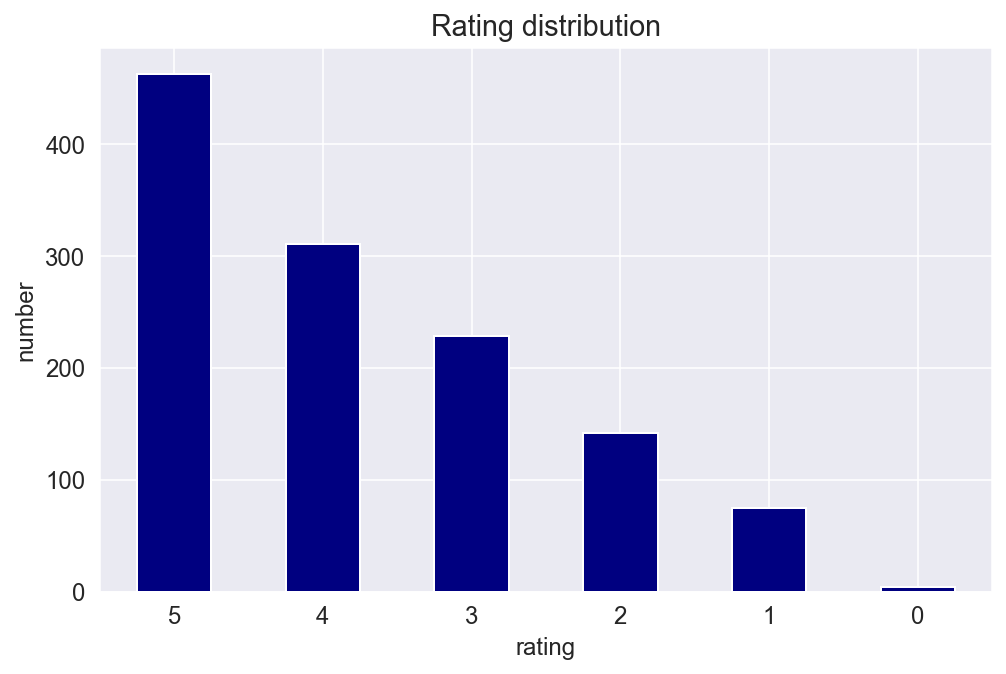

In [125]:
ax = df.rating.value_counts().plot.bar(rot=0, color="navy")
ax.set_xlabel("rating")
ax.set_ylabel("number")
ax.set_title("Rating distribution")

Возникает проблема - на всей выборке средний рейтинг почти, по большей части в целом не опускается ниже 3, судя по первому квартилю

In [119]:
df.rating.describe()

count    1224.000000
mean        3.762255
std         1.256159
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

Поскольку у нас задача бинарной классификации, я решил закодировать всё, что меньше 3, как отрицательный отзыв.

In [127]:
df["sentiment"] = df.rating.apply(lambda x: 1 if x >= 4 else -1)

Text(0.5, 1.0, 'Rating distribution')

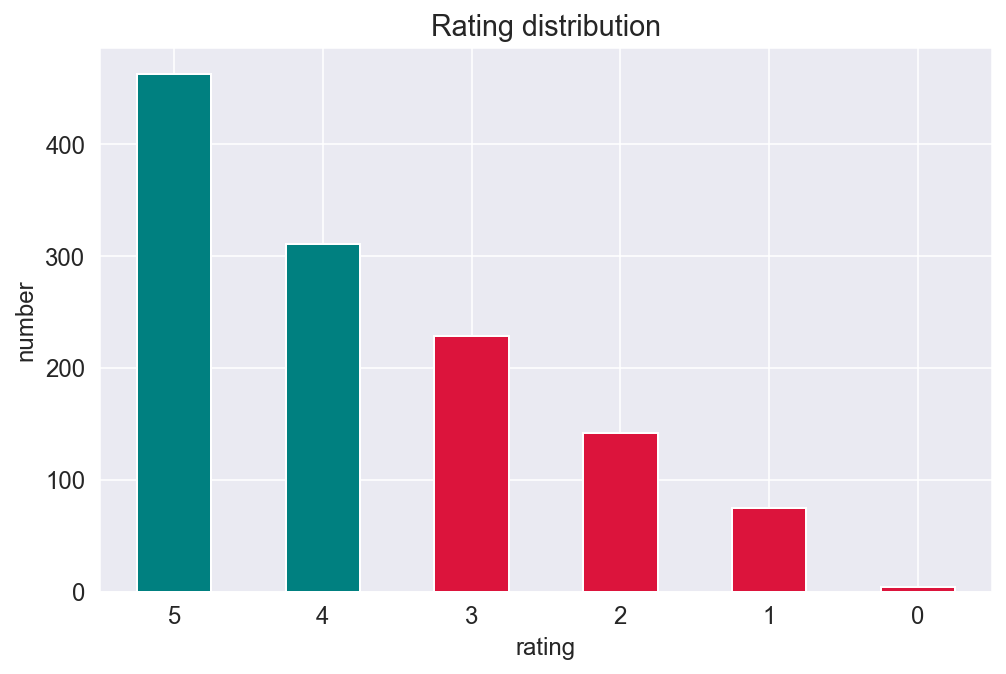

In [126]:
ax = df.rating.value_counts().plot.bar(rot=0, color=["teal"]*2+["crimson"]*4)
ax.set_xlabel("rating")
ax.set_ylabel("number")
ax.set_title("Rating distribution")

В таком случае картина получается более-менее сбалансированной

Text(0.5, 1.0, 'Rating distribution')

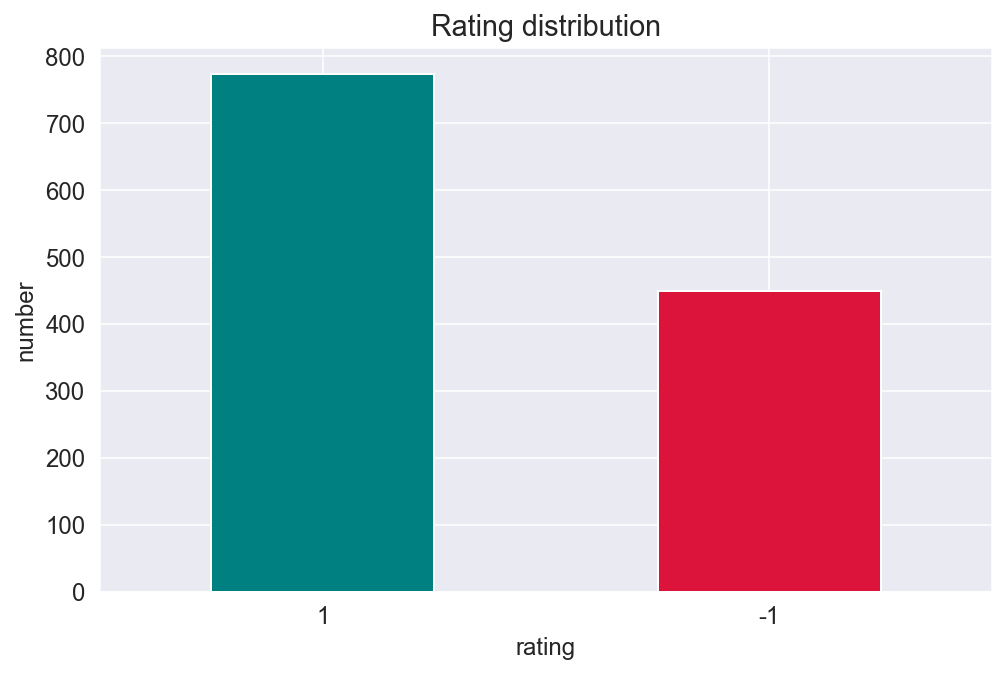

In [128]:
ax = df.sentiment.value_counts().plot.bar(rot=0, color=["teal", "crimson"])
ax.set_xlabel("rating")
ax.set_ylabel("number")
ax.set_title("Rating distribution")

Ну и на самом деле отзывы с рейтингом около 3 довольно часто оказываются именно отрицательными, а не просто нейтральными. По крайней мере там часто есть именно критика, просто обычно в более мягкой форме, чем при рейтинге 2 или 1

In [140]:
for i in df[df.rating == 3].text.sample(5):
    print(i[-300:], end="\n\n")

це. Я не стала его пить без всего, потому что хотелось скорее перебить горечь пенного напитка.  Стоимость одной бутылки - 130 рублей. Цена, по-моему, несколько завышена. Но больше, конечно, в данном, случае отдаешь не за продукт, а за задумку. В общем, данный пенный напиток к покупке не рекомендую. 

 на одном из заводов Балтики в РФ. 
Внешний вид прост. Бледное пиво, почти без пены. Пенной корки нет. Слабый солодовый, без каких либо оттенков. Но и без грязи.  Абсолютно пустое пиво. Чуть кислит. В послевкусии какое-то подобие хмеля.   Единственное достоинство - отсутствие больших недостатков.  

есного от данного сорта явно не стоит. С другой стороны свою цену оно оправдывает, каких то явных косяков я в нём не обнаружил. Учитывая невысокую цену (49,90 рэ), легкодоступность и всё вышесказанное могу смело поставить этому сорту 3 балла. А пить его или не пить пусть каждый сам решает для себя. 

Да, волковскую ипу я считаю эталоном ип до 100 руб, но чувствуется что над апой потрудились мен

2. Токенизируйте слова,  приведите их к нижнему регистру и к начальной форме  (1 балл за токенизацию, 1 - за начальную форму)

In [ ]:
Для токенизации я взял обычные инструменты из nltk плюс немного pymorphy

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import pymorphy2
import string

morph = pymorphy2.MorphAnalyzer()
# беру только буквы, без цифр
tokenizer = RegexpTokenizer(r'[^\d\W]+')
russian_stopwords = stopwords.words("russian")

In [ ]:
Ниже функция, котоой я превращаю отдельный текст в список лемм, от пунктуации чистить токенайзер, от стоп слов чищу сам в функции

In [22]:
def preprocess(text):
    tokens = tokenizer.tokenize(text)
    lemmas = [morph.parse(x)[0].normal_form for x in tokens if x not in russian_stopwords]
    return lemmas

In [141]:
Применяю, получаю список, вношу его в колонку

SyntaxError: invalid syntax (689518925.py, line 1)

In [23]:
df["processed"] = df.text.apply(lambda x: preprocess(x))

3. Составьте 2 множества - в одном будут слова, которые встречаются только в положительных отзывах, а в другом - встречающиеся только в отрицательных. Попробуйте поиграть с частотностями и исключить шум (к примеру, выбросить слова, встречающиеся 1-2 раза) (2 балла) (если у вас получились пустые множества, уберите фильтр по частотности или увеличьте выборку)

Сперва я делю на трейн и тест. Если я хочу получить положительные и отрицательные слова, в идеале они должны быть взяты из трейна, чтобы оценка качества была наиболее правдоподобной

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

y = df.sentiment
X = df.drop("sentiment", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=671, shuffle=True, test_size=10)

In [ ]:
Чтобы получить поляризованные слова, нужно сперва взять просто списки слов из соответствующих подмножеств, засунуть их в какой-нибудь хешируемый объект и взять симметрическую разность

In [186]:
def get_words(X_train, y_train):
    # слова берутся для тренировочной подвыборки
    
    # сперва сливаю X и y обратно, чтобы отделить хорошие и плохие отзывы
    concatted = pd.concat([X_train, y_train], axis=1)
    # беру колонку с леммами
    good_words = concatted[concatted.sentiment == 1].processed
    bad_words = concatted[concatted.sentiment == -1].processed
    
    # суммирую, чтобы получить один большой массив, беру каунтер
    good = Counter(good_words.sum())
    bad = Counter(bad_words.sum())

    # беру разность двух множеств и заново заполняю каунтер,
    # при обычной разности будут вычитаться именно каунты, а я хочу их сохранить
    bad_words = Counter({k : bad[k] for k in set(bad) - set(good)})
    good_words = Counter({k : good[k] for k in set(good) - set(bad)})
    
    return good_words, bad_words

In [204]:
good_words, bad_words = get_words(X_train, y_train)

In [ ]:
Можно дополнительно исключить слишком частые или слишком редкие слова. Я на самом деле думаю, что совсем исключать их не стоит, но об этом в следующем пункте

In [205]:
good_words_filt = Counter({x: good_words[x] for x in good_words if good_words[x] in range(4, 15)})
bad_words_filt = Counter({x: good_words[x] for x in good_words if good_words[x] in range(4, 15)})

4. Создайте функцию, которая будет определять, положительный ли отзыв или отрицательный в зависимости от того, какие слова встретились в нём, и посчитайте качество при помощи accuracy (1  - за коректно работающую функцию, 1 - за подсчёт accuracy)

Я надеюсь, что я правильно понял, что от нас требуется. Если так, то достаточно делает две проверки: прибавлять скор, если слово хорошее, или отнимать. В конце просто возьму максимум между знаком и -1, если положительных слов больше, очевидно он будет 1

In [206]:
def sign(num):
    # не импортировал, потому что 0 я видеть не хочу, а на такое допущение придётся пойти
    # считаем, что нейтральных отзывов не бывает, пока
    return -1 if num <= 0 else 1

In [209]:
def sentiment_prediction(lemmas):
    score = 0
    
    for lemma in lemmas:
        if lemma in good_words:
            score += 1
        elif lemma in bad_words:
            score += -1
        
    return sign(score)

In [210]:
y_pred = X_test.processed.apply(lambda x: sentiment_prediction(x))
accuracy_score(y_pred, y_test)

0.7

Учитывая, что алгоритм супер простой, это наверное неплохо, но если взять тестовую выборку нормального размера, то будет видно, что предсказание довольно грустно. Вспоминаем, что классы у нас несбалансированы, можно было бы брать константный прогноз, было бы не сильно хуже

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=671, shuffle=True, test_size=.3)
good_words, bad_words = get_words(X_train, y_train)

y_pred = X_test.processed.apply(lambda x: sentiment_prediction(x))
accuracy_score(y_pred, y_test)

0.6831683168316832

In [726]:
y_pred = X_test.processed.apply(lambda x: weighted_sentiment_prediction(x))
accuracy_score(y_pred, y_test)

0.6775510204081633

5. Предложите как минимум 2 способа улучшить эту программу с помощью добавления к ней любых мулек (1 балл за описание словами, 2 - если реализуете хотя бы один способ)

Можно сделать много чего:

1. Выборка не очень большая, вполне возможно, что какие-то "хорошие" или "плохие" слова мы не учли, или учли что-то лишнее, это решается просто - надо скачать побольше. Но возможность того, что слово употреблено в каком-то другом значении остаётся. Решение: взять ещё отзывов, можно докачать irecommend, там остановка где-то на 57 странице, или взять отзывы с otzovika, там тоже наберётся где-то 1000, но с ним та же проблема - опять искать прокси
2. Попробовать улучшить текущий алгоритм. Сейчас в нём никак не учитывается собственно частотность слов. Решение: придумать функцию весов. Я уже говорил выше, что радикальный фильтр мне не очень нравится. Я предполагаю, что самые важные слова действительно имеют среднюю частотность - где-то в районе 10, но остальные тоже сойдут, можно учесть.
3. Получившийся алгоритм слишком простой. На самом деле тональность не делится строго бинарно, она может быть смешанная, может быть наполовину негативная и т.д. В таком случае как раз могут помочь рейтинги, которые я тоже собирал, по ним можно построить регрессию и делать не просто оценку тональности, а оценку по 5-балльной шкале. Решение: сделать нормальные эмбеддинги и собрать сложную модель:
1) обучить w2v, но выборка не очень большая, обучение будет поверхностным
2) обучить какой-нибудь векторайзер из sklearn, выборка вроде бы достаточно большая, чтобы вышло что-то осмысленное

Сперва попробуем добавить веса. Я хотел придумать что-нибудь, что будет нормально относится к каунтам близким к 10, сильно обрубать меньший каунт (слишком редкие, чтобы влиять), больший каунт обрубать не так быстро (не знаем точно, стоп-слово или просто частое). Для этого я модифицировал сигмоиду - она почти пологая слева, то, что нужно, прибавил к ней x^2 в знаменателе, чтобы после достижения пика, функция начала убывать примерно как парабола, это не очень быстро с учётом экспоненты, но достаточно, чтобы затухнуть где-то после 20. На графике должно быть достаточно ясно

Text(0.5, 0.98, 'Weight function')

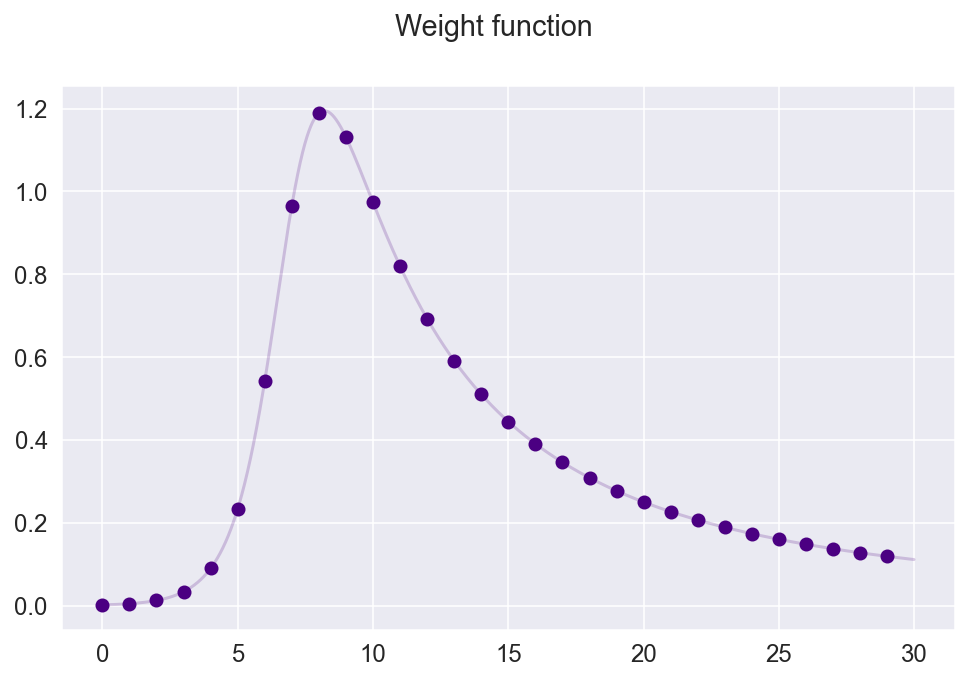

In [238]:
import math
import numpy as np

weight = lambda x: 100 * (1/(x**2 + math.e**(-x+11)))
x_range = range(30)
x_arange = np.arange(0, 30, 0.01)

plt.scatter(x_range, [weight(i) for i in x_range], color="indigo")
plt.plot(x_arange, [weight(i) for i in x_arange], color="indigo", alpha=0.2)
plt.suptitle("Weight function")

In [ ]:
Теперь посмотрим на результат после взвешивания

In [239]:
def weighted_sentiment_prediction(lemmas):
    score = 0
    
    for lemma in lemmas:
        if lemma in good_words:
            score += weight(good_words[lemma])*1
        elif lemma in bad_words:
            score += -weight(bad_words[lemma])*1
        
    return sign(score)

In [243]:
y_pred = X_test.processed.apply(lambda x: sentiment_prediction(x))
f"До: {accuracy_score(y_pred, y_test)}"

'До: 0.6831683168316832'

In [244]:
y_pred = X_test.processed.apply(lambda x: weighted_sentiment_prediction(x))
f"После: {accuracy_score(y_pred, y_test)}"

'После: 0.7062706270627063'

Результат налицо, но этого всё равно мало. Делать нечего, нужны эмбеддинги. Да и задача понимания рейтинга по тексту гораздо интереснее скучной бинарной классификации, там такая функция точно не сработает. Но сперва разберёмся с классификацией

In [30]:
# возьмём другой таргет

y = df[["rating", "sentiment"]]
X = df.drop(["rating", "sentiment"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=671, shuffle=True, test_size=0.2)

In [77]:
X_train.text

267    Приветствую! Этот отзыв для достигших 18+ лет....
521    Сегодня играет сборная России по футболу, а зн...
485    Сегодняшний отзыв о моем любимчике. Я не спец ...
57     В начале 2022г. пивгигант "Балтика", входящая ...
537    Привет любителям пенного, а также сочувствующи...
                             ...                        
664    Зашло, очень неплохой вкус, по сравнению с мно...
687    Пиво Францисканер Вайсбир, на мой взгляд, одно...
735    Здравствуйте. С наступлением тепла у многих от...
289    Всем нам бывает иногда либо хочеться алкоголя,...
691    Чуть было не прошел мимо. Купил и не пожалел. ...
Name: text, Length: 805, dtype: object

Я довольно долго сидел и подбирал параметры, так что везде, где можно было бы взять друой векторайзер, нормализовать, взять другой гиперпараметр в модели и всё такое прочее - да, можно, но скорее всего будет работать хуже. Ниже оптимальные модели, которые нашёл я

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2))
# важно помнить, что текст у меня в отдельной колонке, из неё нужно собрать новую матрицу
X_train_tfidf = tfidf.fit_transform(X_train.processed.apply(lambda x: " ".join(i for i in x)))
X_test_tfidf = tfidf.transform(X_test.processed.apply(lambda x: " ".join(i for i in x)))

In [78]:
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=russian_stopwords)
# важно помнить, что текст у меня в отдельной колонке, из неё нужно собрать новую матрицу
X_train_tfidf = tfidf.fit_transform(X_train.text,)
X_test_tfidf = tfidf.transform(X_test.text)

In [79]:
X_train_tfidf

<805x115329 sparse matrix of type '<class 'numpy.float64'>'
	with 222268 stored elements in Compressed Sparse Row format>

In [ ]:
Сперва так или иначе нужно векторизовать. Tfidf в целом даёт результат чуть получше, но будет обучаться гораздо дольше, так что при проверке придётся немного посидеть. В качестве модели я пробовал logreg, svm с разными ядрами и параметрами, random forest, adaboost и наконец catboost. Лучше всего, и приятнее всего работает последний, его даже объяснять особо не надо, я только надеюсь, что картинка не сломается, когда я сдам тетрадку

In [49]:
from catboost import CatBoostRegressor, CatBoostClassifier

# разбираемся с классификацией
model = CatBoostClassifier(max_depth=9, iterations=200, random_state=671, use_best_model=True)
model.fit(X_train_tfidf, y_train.sentiment, plot=True, eval_set=(X_test_tfidf, y_test.sentiment), verbose=False)
y_pred_class = model.predict(X_test_tfidf)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
Что в итоге получилось:

In [50]:
f"До: {accuracy_score(y_pred_class, y_test.sentiment)}"

'До: 0.7772277227722773'

In [ ]:
Это уже гораздо лучше, теперь попробуем для рейтинга в целом

In [51]:
from catboost import CatBoostRegressor

# теперь для регрессии
model = CatBoostRegressor(loss_function="RMSE", max_depth=9, iterations=300, random_state=671)
model.fit(X_train_tfidf, y_train.rating, plot=True, eval_set=(X_test_tfidf, y_test.rating), verbose=False)
y_pred_class = model.predict(X_test_tfidf)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [65]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred_class, y_test.rating)**(1/2)/5 # беру NRMSE

0.21462765654174776

In [ ]:
Если я понимаю, то это означает, что предсказание рейтинга ошибается примерно на 21%. Если так, то это вполне неплохо. Я думаю, что качество можно увеличить ещё больше, сделать RMSE меньше 1, но совсем чуть-чуть. В любом случае мне надоело крутить параметры, скорее всего это максимум, который можно отсюда выжать без нейросеток. Я бы и её состряпал тоже, но мне уже надоело, да и сел я поздновато

In [ ]:
Кстати, если потом вернуть всё в бинарное поле, то точность чуть-чуть увеличится

In [75]:
vfunc = np.vectorize(lambda x: -1 if x <=3 else 1)
accuracy_score(vfunc(y_pred_class), y_test.sentiment)

0.7871287128712872

In [ ]:
Впрочем, w2v я всё-так обучил, посмотрим, сделает ли он жизнь лучше

In [54]:
pred_text = """В пиве твоя сила и мудрость. Вот, пожалуйста, толстяк. Нормальное пиво. Пацанское, хули. Пить можно. Ну, как его похвалить, ну, заебись пиво. Пиздатое пиво. Как его ещё похвалить, блядь? Хе-хе. Невъебенное пиво. Вот оно, жидкое золото!"""

In [60]:
pred_text = """Теперь пиво 'Невское' в новой оригинальной бутылке, но это не имеет никакого значения, потому что важен только неповторимый, мягкий вкус пива 'Невское', вкус истинного наслаждения. 'Невское', главное - мягкий вкус"""

In [61]:
model.predict(tfidf.transform([" ".join(x for x in preprocess(pred_text))]))

array([4.42758075])

In [85]:
import gensim

In [4]:
y = df.rating
X = df.drop("rating", axis=1)

In [835]:
df.rating.value_counts()

5    463
4    311
3    229
2    142
1     75
0      4
Name: rating, dtype: int64

In [496]:
train_data, test_data = train_test_split(df, random_state=671, shuffle=True, test_size=.2)

In [104]:
w2v = gensim.models.Word2Vec(
            df.processed,
            vector_size=300, # desired no. of features/independent variables
            window=10, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 5, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
)

w2v.train(X_train.processed, total_examples=len(df.processed), epochs=50)

(5614768, 6456400)

In [982]:
w2v.wv.most_similar("пивоман")

[('тунеядец', 0.8316137194633484),
 ('трезвенник', 0.8281012773513794),
 ('огонёк', 0.8229807019233704),
 ('дворовый', 0.8210955262184143),
 ('пополняться', 0.7978492975234985),
 ('передаться', 0.7912670373916626),
 ('sarry', 0.7865998148918152),
 ('случаем', 0.7854784727096558),
 ('пригодиться', 0.7807559370994568),
 ('брам', 0.7742180228233337)]

In [990]:
w2v.wv.most_similar("утро")

[('болеть', 0.673523485660553),
 ('сушняк', 0.6695348024368286),
 ('похмелие', 0.6685926914215088),
 ('боль', 0.6593685746192932),
 ('утром', 0.6555420756340027),
 ('слабость', 0.6552209854125977),
 ('просыпаться', 0.6525158286094666),
 ('наутро', 0.6392948031425476),
 ('побаливать', 0.6218733787536621),
 ('гудеть', 0.6156499981880188)]

In [995]:
w2v.wv.most_similar("алкоголик")

[('тунеядец', 0.7770566344261169),
 ('пивоман', 0.7537947297096252),
 ('начинающий', 0.7358443737030029),
 ('дворовый', 0.7196391820907593),
 ('заядлый', 0.6799221634864807),
 ('трезвенник', 0.6675390005111694),
 ('случаем', 0.6595489978790283),
 ('пьянство', 0.6405438184738159),
 ('потребность', 0.6299386024475098),
 ('огонёк', 0.6250547170639038)]

In [1017]:
w2v.wv.most_similar("пятница")

[('рулить', 0.7115566730499268),
 ('трудный', 0.7040287852287292),
 ('посидеть', 0.6895173788070679),
 ('молодёжь', 0.6876687407493591),
 ('огород', 0.684447169303894),
 ('нарваться', 0.663922131061554),
 ('вечерком', 0.6598960161209106),
 ('диван', 0.6598218083381653),
 ('вечером', 0.6513352394104004),
 ('поболтать', 0.6489312052726746)]

In [1084]:
w2v.wv.most_similar("спирт")

[('этиловый', 0.6411498188972473),
 ('перебродить', 0.5464438199996948),
 ('доля', 0.5423698425292969),
 ('порошок', 0.5349884033203125),
 ('нету', 0.5349371433258057),
 ('бархотистый', 0.5343549847602844),
 ('кратковременный', 0.5287690758705139),
 ('нагнать', 0.5279044508934021),
 ('слабоватый', 0.5222694277763367),
 ('суррогатный', 0.5198664665222168)]

In [81]:
def featureVecMethod(words, model, num_features):
    # сначала нулевой вектор
    featureVec = np.zeros(num_features, dtype="float32")
    nwords = 0
    
    # сет для скорости
    index2word_set = set(model.wv.index_to_key)
    
    # для всех слов в тексте
    for word in words:
        if word in index2word_set:
            # если слово есть в словаре, увеличиваем каунт и компоненту вектора
            nwords = nwords + 1
            featureVec = np.add(featureVec, model.wv[word])
    
    # нормализую по количеству слов
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [82]:
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    # сначала нулевая матрица
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    
    # для каждого отдельного текста в выборке
    for review in reviews:
        # потихоньку заполняю матрицу векторами-текстами
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        # итерируемся по строкам
        counter = counter+1
        
    return reviewFeatureVecs

In [105]:
clean_train_reviews = []
for review in X_train.processed:
    clean_train_reviews.append(review)
    
trainDataVecs = getAvgFeatureVecs(clean_train_reviews, w2v, 300)

In [106]:
test_reviews = []
for review in X_test.processed:
    test_reviews.append(review)
    
testDataVecs = getAvgFeatureVecs(test_reviews, w2v, 300)

In [107]:
trainDataVecs = np.nan_to_num(trainDataVecs)
testDataVecs = np.nan_to_num(testDataVecs)

In [576]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
    
print("Fitting random forest to training data....")    
forest = forest.fit(trainDataVecs, y_train)

Fitting random forest to training data....


In [91]:
from sklearn.svm import LinearSVC

In [108]:
from catboost import CatBoostRegressor

# теперь для регрессии
model = CatBoostRegressor(loss_function="RMSE", max_depth=9, iterations=300, random_state=671)
model.fit(trainDataVecs, y_train.rating, plot=True, eval_set=(testDataVecs, y_test.rating), verbose=False)
y_pred_class = model.predict(testDataVecs)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [98]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred_class, y_test.rating)**(1/2)

1.1187943480843994

In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

In [504]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=671, shuffle=True, test_size=0.2)

In [413]:
torch.Tensor(train_vecs_w2v)[0].shape

torch.Size([300])

In [416]:
Y_train[0].shape

()

In [462]:
Y_train = torch.Tensor(Y_train).unsqueeze(1).type(torch.FloatTensor)

In [510]:
all_words = X.processed.sum()
count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)
print("Top ten occuring words : "+str(sorted_words[:10]))

Top ten occuring words : [('пиво', 7696), ('вкус', 2601), ('это', 2200), ('напиток', 1501), ('очень', 1406), ('в', 1374), ('5', 951), ('который', 906), ('светлый', 898), ('бутылка', 857)]


In [ ]:
vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}
print(vocab_to_int)

In [344]:
lreg = LogisticRegression(solver='lbfgs', max_iter=1000) 

lreg.fit(train_vecs_w2v, y_train)

#test naive bayes accuracy
testLabelsPredicted=list(lreg.predict(test_vecs_w2v))

In [345]:
accuracy_score(lreg.predict(test_vecs_w2v), y_test)

0.726530612244898

In [335]:
scaler = MinMaxScaler()

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train.processed.sum())



TfidfVectorizer()

In [339]:
matrix

<979x1889 sparse matrix of type '<class 'numpy.float64'>'
	with 93102 stored elements in Compressed Sparse Row format>